# Data Generation with Flatland

This notebook begins to outline how training datasets will be generated in Flatland. This notebook will evolve into a documentation of how to use the tool through a more formal and simplified API.

### Here's the idea

Some modern protein structure prediction approaches are a little bit complicated to implement. That's why it seems useful to have a simulator that can generate data at least of the same structure that researchers seek to use in such systems. Over time, these simulators can be improved progressively to add some minimal level of realism that should be helpful for initial model debugging. This might include for example modifying simulation parameters to enable a model to train effectively then returning to the more complex form once the simpler problem has been solved. Thus we hope to create a much more smooth path to solving the larger problem than is often followed by those seeking to solve it directly.

Further, even when training larger systems on real data it will be important that system components remain integrated and both the system and its individual components continue to function correctly. Simple toy test cases are often used for this purpose in software test engineering. But in the case of ML software engineering, sometimes it helps if these are slightly realistic. Even further, we are interested in understanding the potential of various additional sources of data to enhance the performance of structure prediction systems.

Below we will evolve a population of polymers using a trivially simple fitness metric and in the course of that retain a "genetic history" of the evolved population. Then, we will compute structures for these polymers using Jax MD. For each "solved" structure we will compute a pairwise "residue" distance matrix and a vector of "bond" angles. Lastly, we will simulate a compound-protein interaction experiment again using Jax MD.


### Imports

In [ ]:
# For now, at bottom of notebook

### Configuration

In [4]:

alphabet_size = 3
population_size = 500
genome_length = 10
mutation_rate = 0.15
num_generations = 50

dimension = 2
box_size = 6.8

num_water_particles = 100


### Input

The input to this will be a vector specifying which species of particle occur in what order in our polymer, such as the following. I'm so curious how these might fold up and potentially interact!

In [5]:

def fitness_mean_value_target(v, target_value=1.0):
    return 1 - jnp.abs(jnp.mean(v) - target_value)/target_value

@jit
def batched_fitness_mean_value_target(population):
    return vmap(fitness_mean_value_target)(population)

res = evolve_with_mutation(fitness_fn=batched_fitness_mean_value_target,
                           num_generations=num_generations,
                           pop_size=population_size,
                           genome_length=genome_length,
                           mutation_rate=mutation_rate,
                           alphabet_size=alphabet_size,
                           keep_full_population_history=True,
                           key=random.PRNGKey(1))

fitness, population_history, last_population = res


Current average fitness: 0.4998
Current average fitness: 0.8773999999999997
Current average fitness: 0.877
Current average fitness: 0.8784
Current average fitness: 0.8719999999999997


In [6]:
last_population[0:10]

DeviceArray([[2, 0, 0, 1, 2, 2, 0, 2, 0, 1],
             [1, 0, 0, 1, 1, 2, 2, 0, 0, 0],
             [1, 0, 2, 0, 1, 0, 2, 2, 0, 2],
             [2, 2, 0, 1, 0, 2, 1, 2, 0, 1],
             [0, 2, 0, 1, 1, 0, 0, 2, 1, 2],
             [2, 1, 0, 0, 2, 1, 2, 1, 1, 2],
             [0, 1, 1, 1, 1, 2, 0, 2, 0, 2],
             [0, 1, 2, 2, 2, 1, 2, 0, 2, 0],
             [1, 1, 1, 0, 0, 2, 2, 0, 2, 2],
             [2, 1, 2, 0, 1, 0, 1, 2, 1, 1]], dtype=int64)

In [7]:

polymer = last_population[0]
polymer_len = len(polymer)
polymer


DeviceArray([2, 0, 0, 1, 2, 2, 0, 2, 0, 1], dtype=int64)


### Simulate folding

Let's simulate a polymer folding!


Usual Jax MD setup

In [8]:

displacement, shift = space.periodic(box_size)


Define a species matrix describing how pairs should attract or repel

In [9]:

r0_species_matrix = jnp.array(
    [[1.0, 1.0, 0.5 ],
     [1.0, 1.0 , 1.0],
     [0.5, 1.0 , 1.0 ]]
)


Provide the evolved polymer sequence as a species parameter to the "hydrogen bond" energy function

In [10]:

energy_fn = harmonic_morse_pair(displacement, D0=0., alpha=10.0, k=1.0,
                                species=polymer, # <======== Here!! ====================
                                r0=r0_species_matrix)


Compute the initial positions of all of the particles in the polymer

In [11]:

R = jnp.array([[box_size/2, box_size/4 + 0.5*i*box_size/polymer_len] for i in range(polymer_len)])
R


DeviceArray([[3.4 , 1.7 ],
             [3.4 , 2.04],
             [3.4 , 2.38],
             [3.4 , 2.72],
             [3.4 , 3.06],
             [3.4 , 3.4 ],
             [3.4 , 3.74],
             [3.4 , 4.08],
             [3.4 , 4.42],
             [3.4 , 4.76]], dtype=float64)

Specify that polymer elements should be bonded in the order of the provided sequence and compute initial bond lengths

In [12]:

bonds = jnp.array([[i, i+1] for i in range(polymer_len - 1)], dtype=jnp.int64)

lengths = [0]*len(bonds)
for i in range(polymer_len - 1):
    lengths[i] = R[i+1][1] - R[i][1]


This is what that looks like

Combine the "hydrogen" and "covalent" energy functions

In [13]:

bond_energy_fn = bistable_spring_bond(displacement, bonds, r0=lengths)

def combined_energy_fn(R):
  return energy_fn(R) + 2*bond_energy_fn(R)


Find a minimum energy using gradient methods with repeated re-starts / perturbations

Running minimization 0
Perturbing initial conformation...
Minimizing energy...
Computing solved energy...
Energy for this iteration was -3.4932965928780093
Improved lowest energy.
Running minimization 1
Perturbing initial conformation...
Minimizing energy...
Computing solved energy...
Energy for this iteration was -3.4932965928780093
Running minimization 2
Perturbing initial conformation...
Minimizing energy...
Computing solved energy...
Energy for this iteration was -2.9222463611154885
Running minimization 3
Perturbing initial conformation...
Minimizing energy...
Computing solved energy...
Energy for this iteration was -3.4932965928780098
Improved lowest energy.
Running minimization 4
Perturbing initial conformation...
Minimizing energy...
Computing solved energy...
Energy for this iteration was -3.4932965928780093
Lowest energy found was -3.4932965928780093


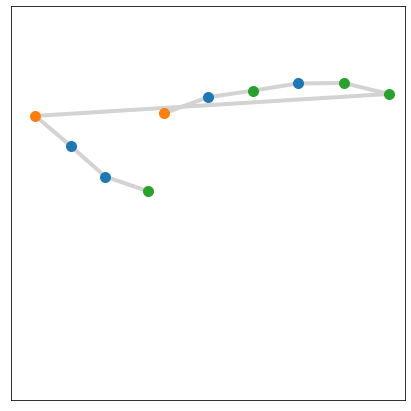

In [14]:

key, subkey1, subkey2 = random.split(key, 3)

perturb_steps = 1000
perturb_kt = 500
e_best = None
R_best = R
minimize_steps = 100000
num_rounds = 5
solutions = [None for _ in range(num_rounds)]
energies = [None for _ in range(num_rounds)]

for i in range(num_rounds):
    
  key, subkey = random.split(key)

  print("Running minimization %s" % i)
  print("Perturbing initial conformation...")
  # Initialize a messy starting structure by simulating 10 steps at 500 kT
  R_current, max_force_component = run_brownian(combined_energy_fn,
                                                #R_best,
                                                R, # <============ Use the initial conformation instead of re-starting
                                                shift,
                                                key=subkey,
                                                num_steps=perturb_steps,
                                                kT=perturb_kt)
  print("Minimizing energy...")
  R_current, max_force_component = run_minimization(combined_energy_fn, R_current, shift, num_steps=minimize_steps)

  print("Computing solved energy...")
  e = combined_energy_fn(R_current)
  print("Energy for this iteration was %s" % e)

  if not e_best or e < e_best:
    e_best = e
    R_best = R_current
    print("Improved lowest energy.")

  solutions[i] = R_current
  energies[i] = e

print("Lowest energy found was %s" % e)
plot_system(R=R_best, box_size=box_size, species=polymer, bonds=bonds)


### Pairwise distances 

Given a "folded" structure, obtain a matrix of pairwise distances and visualize.

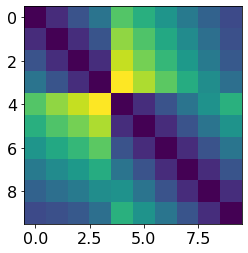

In [16]:

import numpy as np

def compute_distance_matrix(positions):

  distances = np.zeros(shape=(polymer_len, polymer_len))

  for i in range(polymer_len):
    for j in range(polymer_len):
      distances[i][j] = jnp.linalg.norm(positions[i] - positions[j])

  return distances

d = compute_distance_matrix(R_best)

plt.imshow(d)


### Bond angles

Given a "folded" structure, obtain a vector of bond angles.

In [18]:

def compute_angle(p0: jnp.ndarray, p1: jnp.ndarray, p2: jnp.ndarray) -> jnp.float32:
  """Compute the angle centered at `p1` between the other two points."""

  a = p1 - p0
  da = np.linalg.norm(a)

  b = p1 - p2
  db = np.linalg.norm(b)

  c = p0 - p2
  dc = np.linalg.norm(c)

  x = (da**2 + db**2 - dc**2)/(2.0*da*db)

  angle = jnp.arccos(x)*180.0/jnp.pi

  return min(angle, 360 - angle)


p0 = jnp.array([0, 1], dtype=jnp.float32)
p1 = jnp.array([0, 0], dtype=jnp.float32)
p2 = jnp.array([1, 0], dtype=jnp.float32)

assert (90.0 - compute_angle(p0, p1, p2)) < 0.00001


In [19]:

def compute_angles_for_structure(positions: jnp.ndarray) -> jnp.ndarray:

  angles = np.zeros(shape=(len(positions) - 2,))

  for i in range(len(positions) - 2):
    angles[i] = compute_angle(positions[i], positions[i + 1], positions[i + 2])

  return angles

assert (compute_angles_for_structure(jnp.array([[1,0],[0,0],[0,1]])) - jnp.array([90.0])) < 0.000001
angles = compute_angles_for_structure(R)
assert np.array_equal(angles, jnp.array([180.0 for _ in range(8)]))
print(angles)


[180. 180. 180. 180. 180. 180. 180. 180.]


In [21]:
compute_angles_for_structure(R_best)

array([157.33144163, 178.87700804,  43.9409539 ,  17.32420598,
       165.58380656, 171.6196661 , 179.34562477, 168.25388047])

### Adding water

Let's see if adding water and patterns of hydrophobicity can help form more regular structures.


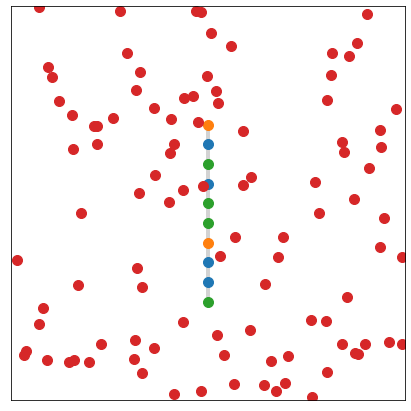

In [22]:

def add_water(key, existing_coordinates, existing_species, num_water_particles, box_size, dimension=2):
  """Add water coordinates and species to an existing system."""

  # Determine the species index for the additional water
  max_species = max(existing_species)
  water_species = max_species + 1

  # Add and additional species index for each additional water particle
  species = jnp.concatenate((existing_species, jnp.array([water_species]*num_water_particles)))

  key, split = random.split(key)
  water_coords = random.uniform(
      key, shape=(num_water_particles, dimension),
      minval=0.0, maxval=box_size)

  coordinates = jnp.concatenate((existing_coordinates, water_coords))

  return jnp.array(coordinates), jnp.array(species)


R_solution, species_solution = add_water(
    key=key, existing_coordinates=R,
    existing_species=polymer,
    num_water_particles=num_water_particles,
    box_size=box_size,
    dimension=dimension)


plot_system(R=R_solution, box_size=box_size, species=species_solution, bonds=bonds)



### Compound-target interactions

It's possible that co- or pre-training on compound-protein or protein-protein interaction datasets will further enhance our ability to predict the structure of proteins. Let's simulate the interaction of two different polymers with a range of compounds the visualize these two "structural spectra".


In [26]:

# Obtain a polymer sequence from the last population
polymer_a = last_population[0]

# 
polymer_a_soln_coords, polymer_a_soln_species = add_water(
    key=key, existing_coordinates=R,
    existing_species=polymer,
    num_water_particles=num_water_particles,
    box_size=box_size,
    dimension=dimension)

polymer_a_structure = fold_polymer(polymer_a)


DeviceArray([2, 0, 0, 1, 2, 2, 0, 2, 0, 1], dtype=int64)

In [27]:
polymer_b = last_population[1]
polymer_b

DeviceArray([1, 0, 0, 1, 1, 2, 2, 0, 0, 0], dtype=int64)

## Planned Additions

* Adding water and water (anti-)affinities
* Ensuring backbone particles stay within reasonable ranges
* Compound-target interactions


## Imports

In [2]:
#@title Imports & Utils
!pip install -q git+https://www.github.com/google/jax-md

import numpy as onp

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition

from functools import partial
import time

f32 = jnp.float32
f64 = jnp.float64

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
#import seaborn as sns 
#sns.set_style(style='white')

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def calculate_bond_data(displacement_or_metric, R, dr_cutoff, species=None):
  if( not(species is None)):
    assert(False)
    
  metric = space.map_product(space.canonicalize_displacement_or_metric(displacement))
  dr = metric(R,R)

  dr_include = jnp.triu(jnp.where(dr<1, 1, 0)) - jnp.eye(R.shape[0],dtype=jnp.int32)
  index_list=jnp.dstack(jnp.meshgrid(jnp.arange(N), jnp.arange(N), indexing='ij'))

  i_s = jnp.where(dr_include==1, index_list[:,:,0], -1).flatten()
  j_s = jnp.where(dr_include==1, index_list[:,:,1], -1).flatten()
  ij_s = jnp.transpose(jnp.array([i_s,j_s]))

  bonds = ij_s[(ij_s!=jnp.array([-1,-1]))[:,1]]
  lengths = dr.flatten()[(ij_s!=jnp.array([-1,-1]))[:,1]]

  return bonds, lengths

def plot_system(R, box_size, species=None, ms=10, bonds=[]):

  R_plt = jnp.array(R)

  for b in bonds:
    idx0 = b[0]
    idx1 = b[1]
    coord_a = R_plt[idx0]
    coord_b = R_plt[idx1]
    plt.plot([coord_a[0], coord_b[0]], [coord_a[1], coord_b[1]], linewidth=4, color="lightgrey")

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
def setup_periodic_box(box_size):
  def displacement_fn(Ra, Rb, **unused_kwargs):
    dR = Ra - Rb
    return jnp.mod(dR + box_size * f32(0.5), box_size) - f32(0.5) * box_size

  def shift_fn(R, dR, **unused_kwargs):
    return jnp.mod(R + dR, box_size)

  return displacement_fn, shift_fn

key = random.PRNGKey(0)

def run_minimization(energy_fn, R_init, shift, num_steps=5000):
  """Minimize the particle conformation with respect to `energy_fn`."""

  dt_start = 0.001
  dt_max   = 0.004

  energy_fn = jit(energy_fn)

  # Instantiate the optimization initial conditions (just R_init) and optimization step function
  # given by the "fire descent" algorithm, sounds like gradient descent.
  init, apply = minimize.fire_descent(energy_fn, shift, dt_start=dt_start, dt_max=dt_max)

  apply = jit(apply)

  @jit
  def scan_fn(state, i):
    return apply(state), 0.

  # Why don't we do scan_fn = jit(scan_fn) if that's how we're jitting the other functions?
  # And do we need to jit any of the energy_fn and apply functions if we are going to jit
  # scan_fn anyway?

  # Initialize the state of the system
  state = init(R_init)

  # Perform num_steps of optimization (through which we could differentiate if we needed to
  # for some reason given we're using lax.scan... probably faster to use lax.scan). 
  state, _ = lax.scan(scan_fn, state, jnp.arange(num_steps))

  return state.position, jnp.amax(jnp.abs(-grad(energy_fn)(state.position)))


def harmonic_morse(dr, D0=5.0, alpha=5.0, r0=1.0, k=50.0, **kwargs):
  """Compute the harmonic morse potential for a pair of particles at distance `dr`."""
  U = jnp.where(dr < r0, 
               0.5 * k * (dr - r0)**2 - D0,
               D0 * (jnp.exp(-2. * alpha * (dr - r0)) - 2. * jnp.exp(-alpha * (dr - r0)))
               )
  return jnp.array(U, dtype=dr.dtype)

def harmonic_morse_pair(
    displacement_or_metric, species=None, D0=5.0, alpha=10.0, r0=1.0, k=50.0):
  """The harmonic morse function over all pairs of particles in a system."""

  # Initialize various parameters of the harmonic morse function
  D0 = jnp.array(D0, dtype=f32)
  alpha = jnp.array(alpha, dtype=f32)
  r0 = jnp.array(r0, dtype=f32)
  k = jnp.array(k, dtype=f32)

  # Pass the harmonic morse function defined above along with its parameters and a
  # displacement/metric function.
  return smap.pair(
      harmonic_morse,
      space.canonicalize_displacement_or_metric(displacement_or_metric),
      species=species,
      D0=D0,
      alpha=alpha,
      r0=r0,
      k=k)

def bistable_spring(dr, r0=1.0, a2=2, a4=5, **kwargs):
  return (a4*(dr-r0)**4 - a2*(dr-r0)**2)

def bistable_spring_bond(
    displacement_or_metric, bond, bond_type=None, r0=1, a2=2, a4=5):
  """Convenience wrapper to compute energy of particles bonded by springs."""
  r0 = jnp.array(r0, f32)
  a2 = jnp.array(a2, f32)
  a4 = jnp.array(a4, f32)
  return smap.bond(
    bistable_spring,
    space.canonicalize_displacement_or_metric(displacement_or_metric),
    bond,
    bond_type,
    r0=r0,
    a2=a2,
    a4=a4)

def run_brownian(energy_fn, R_init, shift, key, num_steps, kT):

  init, apply = simulate.brownian(energy_fn, shift, dt=0.00001, kT=kT, gamma=0.1)

  apply = jit(apply)

  @jit
  def scan_fn(state, current_step):
    # Dynamically pass r0 to apply, which passes it on to energy_fn
    return apply(state), 0

  key, split = random.split(key)
  state = init(split, R_init)

  state, _ = lax.scan(scan_fn, state, jnp.arange(num_steps))

  return state.position, jnp.amax(jnp.abs(-grad(energy_fn)(state.position)))


In [3]:

import jax.numpy as jnp
from jax import random, jit, vmap
from matplotlib import pyplot
import numpy as np
key = random.PRNGKey(1234)

def generate_population(key, length=10, pop_size=10):
    return random.randint(minval=0, maxval=4, shape=(pop_size,length), key=key)

def fitness_mean_value_target(v, target_value=1.0):
    return 1 - jnp.abs(jnp.mean(v) - target_value)/target_value

@jit
def batched_fitness_mean_value_target(population):
    return vmap(fitness_mean_value_target)(population)

def mutate_population(key, population, mutation_rate=0.15,
                      alphabet_size=4):

    individual_p_mutation = mutation_rate/alphabet_size
    # Lazily double-counts self-transitions as a type of mutation
    # in the interest of prototyping
    p_no_mutation = (1 - mutation_rate)
    mutation_probs = [
        individual_p_mutation for _ in range(alphabet_size)
    ]
    mutation_probs = [p_no_mutation] + mutation_probs

    mutation = random.choice(
        key,
        a=jnp.array(range(alphabet_size + 1)),
        shape=population.shape,
        p=jnp.array(mutation_probs))

    return jnp.mod(population + mutation, alphabet_size - 1)

def resample_population(key, population, fitnesses):
    retain_members = random.choice(
        key=key,
        a=jnp.array([i for i in range(population.shape[0])]),
        shape=(population.shape[0],),
        p=fitnesses, replace=True)
    return jnp.stack([population[i] for i in retain_members])

def evolve_with_mutation(key,
                         fitness_fn,
                         keep_full_population_history=False,
                         num_generations=100, pop_size=100,
                         genome_length=10, report_every=10,
                         mutation_rate=0.15,
                         alphabet_size=4):

    base_mutation_rate = mutation_rate

    fitness_history = np.zeros(shape=(num_generations,))
    
    population_history = None
    if keep_full_population_history:
        population_history = np.zeros(shape=(num_generations, pop_size, genome_length))
    
    population = generate_population(
        key=key,
        length=genome_length,
        pop_size=pop_size)       

    for i in range(num_generations):

        if keep_full_population_history:
            # Could keep track at any point in this loop, making sure
            # at least fitness_history and population_history are in
            # sync.
            population_history[i] = population

        fitnesses = fitness_fn(population)
        fitness_history[i] = jnp.mean(fitnesses)
        max_fitness = jnp.max(fitnesses)
        min_fitness = jnp.min(fitnesses)
        epsilon = 0.000000000000001
        norm_fitnesses = (fitnesses - min_fitness + epsilon)/(max_fitness - min_fitness + epsilon)

        if i % report_every == 0.0:
            print("Current average fitness: %s" % jnp.mean(fitnesses))

        key, _ = random.split(key)
        population = resample_population(
            key=key,
            population=population,
            fitnesses=norm_fitnesses)

        mutation_rate = base_mutation_rate*(1-jnp.mean(norm_fitnesses)/2)

        key, _ = random.split(key)
        population = mutate_population(
            key, population,
            mutation_rate=mutation_rate
        )

    return fitness_history, population_history, population
